# Classification Training Pipeline

This notebook implements a complete Graph Neural Network (GNN) pipeline for a 3-class classification task (`Low`, `Medium`, `High`).  It now includes additional metrics in hyperparameter tuning and enhanced model comparison visualizations.

## Table of Contents
1. [Environment & Setup](#step1)
2. [Model Definition](#step2)
3. [Evaluation Function](#step3)
4. [Hyperparameter Sweep (10-Fold CV)](#step4)
5. [Retraining & Validation (10-Fold CV)](#step5)
6. [Cross-Validation Results Visualization](#step6)
7. [Ensemble Averaging](#step7)
8. [Final Model Training & Test Evaluation](#step8)
9. [Baseline QSAR Comparison](#step9)

---

## Prerequisites
- PyTorch & PyTorch Geometric  
- scikit-learn  
- pandas, numpy, matplotlib  
- RDKit (only for feature extraction)  
- GPU recommended

Install requirements:
```bash
pip install torch torch-geometric scikit-learn pandas numpy matplotlib rdkit-pypi
```

---

<a id="step1"></a>
## Step 1: Environment & Setup
- Seed all random generators for reproducibility.  
- Define paths for data splits and output.  
- Detect GPU/CPU.

<a id="step2"></a>
## Step 2: Model Definition
Defines:
- `edgeGCN` Taking into account edge features  
- `DeepGNNWithEdgeFeatures`: GCN with GraphSAGE, incorporating edge features, global mean pool, and final linear head.

<a id="step3"></a>
## Step 3: Evaluation Function
`evaluate(model, loader)` returns concatenated logits and true labels.

<a id="step4"></a>
## Step 4: Hyperparameter Sweep (10-Fold CV)
**Updates:** Now tracks both **AUC-ROC** and **Balanced Accuracy** per fold.

- Grid search over `hidden_channels`, `dropout`, `lr`.  
- For each config, run 10-fold CV: train for 50 epochs, then evaluate validation set.
- Compute per-fold metrics:
  - **AUC-ROC** (one-vs-rest)
  - **Balanced Accuracy** (accounts for class imbalance)
- Record **mean ± std** for both metrics.
- Results DataFrame `sweep_df` now contains `mean_auc`, `std_auc`, `mean_balanced_acc`, and `std_balanced_acc`.

<a id="step5"></a>
## Step 5: Retraining & Validation (10-Fold CV)
- Retrain each fold with best hyperparameters and early stopping.  
- Save best model weights.  
- Compute per-fold classification metrics: accuracy, precision, recall, F1, AUC-ROC.  
- Save `crossval_summary.csv`.

<a id="step6"></a>
## Step 6: Cross-Validation Results Visualization
- Load `crossval_summary.csv`.  
- Plot bar charts for each metric across folds.  
- Print mean ± std.

<a id="step7"></a>
## Step 7: Ensemble Averaging
- Load fold checkpoints, run on test set, average logits.  
- Save `ensemble_preds.csv` (True vs. Pred).
- **Ensemble evaluation plots** include confusion matrix and per-class ROC curves.

<a id="step8"></a>
## Step 8: Final Model Training & Test Evaluation
- Merge all train+val folds, reserve 10% for validation.  
- Train final model with early stopping and LR scheduler.  
- Evaluate on hold-out test: accuracy, precision, recall, F1, AUC-ROC.
- Plot confusion matrix and per-class ROC curves.  
- Save `final_model_metrics.csv`, `final_confusion_matrix.png`, and `final_auc_roc.png`.


---

## Parameters & Extensions
- **Epochs:** 50 for CV, 100 for final training  
- **Patience:** 10 for early stopping  
- **LR Scheduler:** `ReduceLROnPlateau` on validation loss  





## 1. Imports and Setup

In [1]:
import torch
import torch.nn.functional as F
from torch.nn import Linear
from torch_geometric.loader import DataLoader
from torch_geometric.nn import MessagePassing, global_mean_pool
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import (
    accuracy_score, precision_recall_fscore_support, roc_auc_score,
    confusion_matrix, ConfusionMatrixDisplay, roc_curve, auc,
    mean_absolute_error, mean_squared_error, r2_score
)
from sklearn.preprocessing import label_binarize
from sklearn.model_selection import train_test_split, StratifiedShuffleSplit
import random

C:\Users\johng23\anaconda3\envs\erdos_spring_2025\Lib\site-packages\torch_geometric\typing.py:97: UserWarning: An issue occurred while importing 'torch-cluster'. Disabling its usage. Stacktrace: [WinError 127] The specified procedure could not be found
  warnings.warn(f"An issue occurred while importing 'torch-cluster'. "
C:\Users\johng23\anaconda3\envs\erdos_spring_2025\Lib\site-packages\torch_geometric\typing.py:113: UserWarning: An issue occurred while importing 'torch-spline-conv'. Disabling its usage. Stacktrace: [WinError 127] The specified procedure could not be found
  warnings.warn(


## 2. Task and Reproducibility Setup

In [2]:
# Set seeds
seed = 42
random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark     = False

# DataLoader seeding
from torch.utils.data import DataLoader as _DL
from torch.utils.data import get_worker_info

def seed_worker(worker_id):
    worker_seed = seed + worker_id
    np.random.seed(worker_seed)
    random.seed(worker_seed)

generator = torch.Generator()
generator.manual_seed(seed)

task = "classification"  # or "regression"
#task = "regression"  # or "classification"
num_classes = 3
class_names = {0: "Low", 1: "Medium", 2: "High"}
kfold = 10
base_path = f"../4_train_test_split/10fold_cv/{task}/"
results_dir = f"GraphSAGE_results/{task}_{kfold}fold/"
os.makedirs(results_dir, exist_ok=True)

## 3b. Define GraphSAGE Layer and GraphSAGE Model

In [17]:
import torch
import torch.nn.functional as F
from torch_geometric.nn import MessagePassing, global_mean_pool
from torch.nn import LayerNorm

class EdgeGNNLayer(MessagePassing):
    def __init__(self, in_channels, out_channels, edge_channels, mlp_depth=2):
        """
        Args:
            in_channels (int): Dimension of node features coming in.
            out_channels (int): Dimension of node features going out.
            edge_channels (int): Dimension of edge features.
            mlp_depth (int): Number of hidden layers in the MLPs (minimum 1).
        """
        super(EdgeGNNLayer, self).__init__(aggr='add')
        
        # Build a deeper node MLP: input dimension is (in_channels + edge_channels)
        node_mlp_layers = []
        input_dim = in_channels + edge_channels
        hidden_channels = out_channels  # could also set a different hidden dimension if needed
        for _ in range(mlp_depth - 1):
            node_mlp_layers.append(torch.nn.Linear(input_dim, hidden_channels))
            node_mlp_layers.append(torch.nn.ReLU())
            input_dim = hidden_channels
        node_mlp_layers.append(torch.nn.Linear(input_dim, out_channels))
        self.node_mlp = torch.nn.Sequential(*node_mlp_layers)
        
        # Build a deeper edge MLP for transforming edge features
        edge_mlp_layers = []
        input_dim_e = edge_channels
        hidden_channels_e = edge_channels  # preserving the original dimension
        for _ in range(mlp_depth - 1):
            edge_mlp_layers.append(torch.nn.Linear(input_dim_e, hidden_channels_e))
            edge_mlp_layers.append(torch.nn.ReLU())
            input_dim_e = hidden_channels_e
        edge_mlp_layers.append(torch.nn.Linear(input_dim_e, edge_channels))
        self.edge_mlp = torch.nn.Sequential(*edge_mlp_layers)

    def forward(self, x, edge_index, edge_attr):
        # Transform edge features through a deeper MLP
        edge_attr = self.edge_mlp(edge_attr)
        # Propagate messages
        return self.propagate(edge_index, x=x, edge_attr=edge_attr)

    def message(self, x_j, edge_attr):
        # Concatenate neighboring node features with corresponding edge features
        return torch.cat([x_j, edge_attr], dim=1)

    def update(self, aggr_out):
        # Update node features after aggregation using the deeper MLP
        return self.node_mlp(aggr_out)

class DeepGNNWithEdgeFeatures(torch.nn.Module):
    def __init__(self, in_channels, edge_channels, hidden_channels, out_channels, num_layers=6, mlp_depth=3, dropout=0.5):
        """
        Args:
            in_channels (int): Dimension of initial node features.
            edge_channels (int): Dimension of edge features.
            hidden_channels (int): Dimension for hidden layers.
            out_channels (int): Dimension for output.
            num_layers (int): Number of message passing layers.
            mlp_depth (int): Depth of the MLPs inside each message passing layer.
            dropout (float): Dropout probability for the output MLP.
        """
        super(DeepGNNWithEdgeFeatures, self).__init__()
        self.lin_in = torch.nn.Linear(in_channels, hidden_channels)
        
        # Stack multiple message passing layers and norm layers.
        self.layers = torch.nn.ModuleList()
        self.norms = torch.nn.ModuleList()
        for _ in range(num_layers):
            self.layers.append(EdgeGNNLayer(hidden_channels, hidden_channels, edge_channels, mlp_depth=mlp_depth))
            self.norms.append(LayerNorm(hidden_channels))
        
        # A deeper output MLP to further transform after pooling.
        self.lin_out = torch.nn.Sequential(
            torch.nn.Linear(hidden_channels, hidden_channels),
            torch.nn.ReLU(),
            torch.nn.Dropout(dropout),
            torch.nn.Linear(hidden_channels, hidden_channels),
            torch.nn.ReLU(),
            torch.nn.Dropout(dropout),
            torch.nn.Linear(hidden_channels, out_channels)
        )

    def forward(self, data):
        x, edge_index, edge_attr, batch = data.x, data.edge_index, data.edge_attr, data.batch
        
        # Initial feature transformation
        x = F.relu(self.lin_in(x))
        
        # Passing through deeper stack of message passing layers with residual connections
        for layer, norm in zip(self.layers, self.norms):
            x_res = x  # save for residual connection
            x = layer(x, edge_index, edge_attr)
            x = x + x_res  # add residual connection
            x = norm(x)
            x = F.relu(x)
        
        # Global pooling over nodes for each graph
        x = global_mean_pool(x, batch)
        
        # Final transformation for graph-level output
        return self.lin_out(x)


## 4. Evaluation Helper Function

In [18]:
def evaluate(model, loader):
    model.eval()
    preds, labels = [], []
    with torch.no_grad():
        for batch in loader:
            batch = batch.to(device)
            out = model(batch)
            preds.append(out.cpu())
            labels.append(batch.y.cpu())
    return torch.cat(preds), torch.cat(labels)

## 5. Input Dimensions and Device Setup

In [19]:
sample_data = torch.load(os.path.join(base_path, f"{task}_train_fold0.pt"))[0]
input_dim = sample_data.x.size(1)
edge_dim = sample_data.edge_attr.size(1)
out_channels = num_classes if task == "classification" else 1
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

C:\Users\johng23\AppData\Local\Temp\ipykernel_8584\303463795.py:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  sample_data = torch.load(os.path.join(base_path, f"{task}_tr

# ## Step 4: Select Best Hyperparameters
# Use this section to manually define the best hyperparameters based on the sweep above.


In [20]:
from sklearn.metrics import roc_auc_score, balanced_accuracy_score
from sklearn.preprocessing import label_binarize
import numpy as np
import pandas as pd

hidden_channelss = [64, 128, 256]
dropouts    = [0.0, 0.2, 0.4]
lrs         = [1e-3, 5e-4, 1e-4]

results = []

for hd in hidden_channelss:
    for dp in dropouts:
        for lr in lrs:
            print(f"\n🔧 Config: hidden_channels={hd}, dropout={dp}, lr={lr}")
            auc_scores = []
            bal_scores = []
            for fold in range(10):
                # Load fold data
                train_data = torch.load(os.path.join(base_path, f"{task}_train_fold{fold}.pt"))
                val_data   = torch.load(os.path.join(base_path, f"{task}_val_fold{fold}.pt"))
                
                model = DeepGNNWithEdgeFeatures(train_data[0].x.size(1),
                             train_data[0].edge_attr.size(1),
                             hidden_channels=hd,
                             out_channels=num_classes,
                             dropout=dp).to(device)
                opt = torch.optim.Adam(model.parameters(), lr=lr)
                tr = DataLoader(train_data, batch_size=32, shuffle=True,
                                worker_init_fn=seed_worker, generator=generator)
                vl = DataLoader(val_data,   batch_size=32)

                # Train
                for epoch in range(1, 51):
                    model.train()
                    for batch in tr:
                        batch = batch.to(device)
                        opt.zero_grad()
                        out = model(batch)
                        loss = F.cross_entropy(out, batch.y.long())
                        loss.backward()
                        opt.step()

                # Eval
                preds, labels = evaluate(model, vl)
                y_true = labels.numpy().astype(int)
                y_probs = F.softmax(preds, dim=1).numpy()
                y_pred  = preds.argmax(dim=1).numpy()

                # AUC‑ROC (one-vs-rest)
                auc = roc_auc_score(
                    label_binarize(y_true, classes=np.arange(num_classes)),
                    y_probs, multi_class='ovr'
                )
                auc_scores.append(auc)

                # Balanced Accuracy
                bal = balanced_accuracy_score(y_true, y_pred)
                bal_scores.append(bal)

            # Record mean±std for both metrics
            results.append({
                "hidden_channels": hd,
                "dropout":    dp,
                "lr":         lr,
                "mean_auc":   np.mean(auc_scores),
                "std_auc":    np.std(auc_scores),
                "mean_balanced_acc": np.mean(bal_scores),
                "std_balanced_acc":  np.std(bal_scores),
            })

            print(f"📊 AUC: {np.mean(auc_scores):.4f} ± {np.std(auc_scores):.4f} | "
                  f"Balanced Acc: {np.mean(bal_scores):.4f} ± {np.std(bal_scores):.4f}")

# Build DataFrame and sort by mean balanced accuracy (or mean_auc)
sweep_df = pd.DataFrame(results)
display(sweep_df.sort_values("mean_balanced_acc", ascending=False))
# Save the results
sweep_df.to_csv(os.path.join(results_dir, "sweep_results.csv"), index=False)



🔧 Config: hidden_channels=64, dropout=0.0, lr=0.001


C:\Users\johng23\AppData\Local\Temp\ipykernel_8584\651385742.py:20: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  train_data = torch.load(os.path.join(base_path, f"{task}_tr

📊 AUC: 0.7901 ± 0.0516 | Balanced Acc: 0.5355 ± 0.0753

🔧 Config: hidden_channels=64, dropout=0.0, lr=0.0005


C:\Users\johng23\AppData\Local\Temp\ipykernel_8584\651385742.py:20: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  train_data = torch.load(os.path.join(base_path, f"{task}_tr

📊 AUC: 0.8057 ± 0.0353 | Balanced Acc: 0.4910 ± 0.0513

🔧 Config: hidden_channels=64, dropout=0.0, lr=0.0001


C:\Users\johng23\AppData\Local\Temp\ipykernel_8584\651385742.py:20: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  train_data = torch.load(os.path.join(base_path, f"{task}_tr

📊 AUC: 0.7728 ± 0.0422 | Balanced Acc: 0.4659 ± 0.0383

🔧 Config: hidden_channels=64, dropout=0.2, lr=0.001


C:\Users\johng23\AppData\Local\Temp\ipykernel_8584\651385742.py:20: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  train_data = torch.load(os.path.join(base_path, f"{task}_tr

📊 AUC: 0.7923 ± 0.0520 | Balanced Acc: 0.5269 ± 0.0898

🔧 Config: hidden_channels=64, dropout=0.2, lr=0.0005


C:\Users\johng23\AppData\Local\Temp\ipykernel_8584\651385742.py:20: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  train_data = torch.load(os.path.join(base_path, f"{task}_tr

📊 AUC: 0.7960 ± 0.0285 | Balanced Acc: 0.4875 ± 0.0260

🔧 Config: hidden_channels=64, dropout=0.2, lr=0.0001


C:\Users\johng23\AppData\Local\Temp\ipykernel_8584\651385742.py:20: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  train_data = torch.load(os.path.join(base_path, f"{task}_tr

📊 AUC: 0.7674 ± 0.0492 | Balanced Acc: 0.4473 ± 0.0701

🔧 Config: hidden_channels=64, dropout=0.4, lr=0.001


C:\Users\johng23\AppData\Local\Temp\ipykernel_8584\651385742.py:20: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  train_data = torch.load(os.path.join(base_path, f"{task}_tr

📊 AUC: 0.7781 ± 0.0448 | Balanced Acc: 0.4909 ± 0.0330

🔧 Config: hidden_channels=64, dropout=0.4, lr=0.0005


C:\Users\johng23\AppData\Local\Temp\ipykernel_8584\651385742.py:20: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  train_data = torch.load(os.path.join(base_path, f"{task}_tr

📊 AUC: 0.7687 ± 0.0364 | Balanced Acc: 0.4860 ± 0.0388

🔧 Config: hidden_channels=64, dropout=0.4, lr=0.0001


C:\Users\johng23\AppData\Local\Temp\ipykernel_8584\651385742.py:20: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  train_data = torch.load(os.path.join(base_path, f"{task}_tr

📊 AUC: 0.7527 ± 0.0555 | Balanced Acc: 0.4542 ± 0.0598

🔧 Config: hidden_channels=128, dropout=0.0, lr=0.001


C:\Users\johng23\AppData\Local\Temp\ipykernel_8584\651385742.py:20: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  train_data = torch.load(os.path.join(base_path, f"{task}_tr

📊 AUC: 0.8141 ± 0.0408 | Balanced Acc: 0.5338 ± 0.0697

🔧 Config: hidden_channels=128, dropout=0.0, lr=0.0005


C:\Users\johng23\AppData\Local\Temp\ipykernel_8584\651385742.py:20: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  train_data = torch.load(os.path.join(base_path, f"{task}_tr

📊 AUC: 0.8028 ± 0.0507 | Balanced Acc: 0.5733 ± 0.0753

🔧 Config: hidden_channels=128, dropout=0.0, lr=0.0001


C:\Users\johng23\AppData\Local\Temp\ipykernel_8584\651385742.py:20: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  train_data = torch.load(os.path.join(base_path, f"{task}_tr

📊 AUC: 0.7882 ± 0.0285 | Balanced Acc: 0.4946 ± 0.0327

🔧 Config: hidden_channels=128, dropout=0.2, lr=0.001


C:\Users\johng23\AppData\Local\Temp\ipykernel_8584\651385742.py:20: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  train_data = torch.load(os.path.join(base_path, f"{task}_tr

📊 AUC: 0.7934 ± 0.0511 | Balanced Acc: 0.5473 ± 0.0726

🔧 Config: hidden_channels=128, dropout=0.2, lr=0.0005


C:\Users\johng23\AppData\Local\Temp\ipykernel_8584\651385742.py:20: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  train_data = torch.load(os.path.join(base_path, f"{task}_tr

📊 AUC: 0.8020 ± 0.0368 | Balanced Acc: 0.5165 ± 0.0707

🔧 Config: hidden_channels=128, dropout=0.2, lr=0.0001


C:\Users\johng23\AppData\Local\Temp\ipykernel_8584\651385742.py:20: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  train_data = torch.load(os.path.join(base_path, f"{task}_tr

📊 AUC: 0.7874 ± 0.0194 | Balanced Acc: 0.4920 ± 0.0344

🔧 Config: hidden_channels=128, dropout=0.4, lr=0.001


C:\Users\johng23\AppData\Local\Temp\ipykernel_8584\651385742.py:20: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  train_data = torch.load(os.path.join(base_path, f"{task}_tr

📊 AUC: 0.7817 ± 0.0461 | Balanced Acc: 0.5000 ± 0.0355

🔧 Config: hidden_channels=128, dropout=0.4, lr=0.0005


C:\Users\johng23\AppData\Local\Temp\ipykernel_8584\651385742.py:20: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  train_data = torch.load(os.path.join(base_path, f"{task}_tr

📊 AUC: 0.7964 ± 0.0444 | Balanced Acc: 0.4943 ± 0.0452

🔧 Config: hidden_channels=128, dropout=0.4, lr=0.0001


C:\Users\johng23\AppData\Local\Temp\ipykernel_8584\651385742.py:20: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  train_data = torch.load(os.path.join(base_path, f"{task}_tr

📊 AUC: 0.7776 ± 0.0341 | Balanced Acc: 0.4914 ± 0.0344

🔧 Config: hidden_channels=256, dropout=0.0, lr=0.001


C:\Users\johng23\AppData\Local\Temp\ipykernel_8584\651385742.py:20: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  train_data = torch.load(os.path.join(base_path, f"{task}_tr

📊 AUC: 0.7846 ± 0.0643 | Balanced Acc: 0.5484 ± 0.0983

🔧 Config: hidden_channels=256, dropout=0.0, lr=0.0005


C:\Users\johng23\AppData\Local\Temp\ipykernel_8584\651385742.py:20: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  train_data = torch.load(os.path.join(base_path, f"{task}_tr

📊 AUC: 0.8148 ± 0.0427 | Balanced Acc: 0.6257 ± 0.0798

🔧 Config: hidden_channels=256, dropout=0.0, lr=0.0001


C:\Users\johng23\AppData\Local\Temp\ipykernel_8584\651385742.py:20: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  train_data = torch.load(os.path.join(base_path, f"{task}_tr

📊 AUC: 0.8082 ± 0.0278 | Balanced Acc: 0.4906 ± 0.0388

🔧 Config: hidden_channels=256, dropout=0.2, lr=0.001


C:\Users\johng23\AppData\Local\Temp\ipykernel_8584\651385742.py:20: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  train_data = torch.load(os.path.join(base_path, f"{task}_tr

📊 AUC: 0.7203 ± 0.1307 | Balanced Acc: 0.4748 ± 0.0941

🔧 Config: hidden_channels=256, dropout=0.2, lr=0.0005


C:\Users\johng23\AppData\Local\Temp\ipykernel_8584\651385742.py:20: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  train_data = torch.load(os.path.join(base_path, f"{task}_tr

📊 AUC: 0.8042 ± 0.0362 | Balanced Acc: 0.5459 ± 0.0777

🔧 Config: hidden_channels=256, dropout=0.2, lr=0.0001


C:\Users\johng23\AppData\Local\Temp\ipykernel_8584\651385742.py:20: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  train_data = torch.load(os.path.join(base_path, f"{task}_tr

📊 AUC: 0.8068 ± 0.0308 | Balanced Acc: 0.4926 ± 0.0329

🔧 Config: hidden_channels=256, dropout=0.4, lr=0.001


C:\Users\johng23\AppData\Local\Temp\ipykernel_8584\651385742.py:20: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  train_data = torch.load(os.path.join(base_path, f"{task}_tr

📊 AUC: 0.7612 ± 0.0672 | Balanced Acc: 0.4914 ± 0.0767

🔧 Config: hidden_channels=256, dropout=0.4, lr=0.0005


C:\Users\johng23\AppData\Local\Temp\ipykernel_8584\651385742.py:20: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  train_data = torch.load(os.path.join(base_path, f"{task}_tr

📊 AUC: 0.7859 ± 0.0505 | Balanced Acc: 0.5439 ± 0.0749

🔧 Config: hidden_channels=256, dropout=0.4, lr=0.0001


C:\Users\johng23\AppData\Local\Temp\ipykernel_8584\651385742.py:20: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  train_data = torch.load(os.path.join(base_path, f"{task}_tr

📊 AUC: 0.7876 ± 0.0311 | Balanced Acc: 0.4980 ± 0.0298


,hidden_channels,dropout,lr,mean_auc,std_auc,mean_balanced_acc,std_balanced_acc
19,256,0.0,0.0005,0.814831,0.042704,0.625729,0.079828
10,128,0.0,0.0005,0.802790,0.050707,0.573311,0.075315
18,256,0.0,0.0010,0.784573,0.064326,0.548372,0.098294
12,128,0.2,0.0010,0.793408,0.051075,0.547259,0.072612
22,256,0.2,0.0005,0.804171,0.036199,0.545932,0.077693
25,256,0.4,0.0005,0.785911,0.050527,0.543856,0.074944
0,64,0.0,0.0010,0.790098,0.051611,0.535519,0.075337
9,128,0.0,0.0010,0.814092,0.040789,0.533769,0.069696
3,64,0.2,0.0010,0.792286,0.052013,0.526942,0.089833
13,128,0.2,0.0005,0.801973,0.036753,0.516497,0.070678


In [36]:
# Best config: hidden_channels=256, dropout=0.0, lr=0.0005
# Load the best model configuration
best_config = sweep_df.loc[sweep_df["mean_balanced_acc"].idxmax()]
best_hidden_channels = int(best_config["hidden_channels"])
best_dropout = best_config["dropout"]
best_lr = best_config["lr"]
print(f"Best config: hidden_channels={best_hidden_channels}, dropout={best_dropout}, lr={best_lr}")

Best config: hidden_channels=256, dropout=0.0, lr=0.0005


# ## Step 5a: Retrain All Folds with Best Hyperparameters

In [32]:
# %%
from sklearn.metrics import accuracy_score, precision_recall_fscore_support, roc_auc_score
import pandas as pd
fold_metrics = []


for fold in range(10):
    print(f"\n🔁 Retraining Fold {fold+1}/10")
    
    train_data = torch.load(os.path.join(base_path, f"{task}_train_fold{fold}.pt"))
    val_data   = torch.load(os.path.join(base_path, f"{task}_val_fold{fold}.pt"))
    
    model = DeepGNNWithEdgeFeatures(train_data[0].x.size(1),
                 train_data[0].edge_attr.size(1),
                 hidden_channels=best_hidden_channels,
                 out_channels=num_classes,
                 dropout=best_dropout).to(device)
    opt = torch.optim.Adam(model.parameters(), lr=best_lr)
    train_loader = DataLoader(train_data, batch_size=32, shuffle=True,
                    worker_init_fn=seed_worker, generator=generator)
    val_loader = DataLoader(val_data,   batch_size=32)

    best_val_loss = float('inf'); patience=0
    for epoch in range(1, 101):
        model.train(); total=0
        for batch in tr:
            batch=batch.to(device); opt.zero_grad(); out=model(batch)
            loss=F.cross_entropy(out,batch.y.long()); loss.backward(); opt.step(); total+=loss.item()
        preds, labels = evaluate(model, vl)
        y_true = labels.numpy().astype(int)
        y_probs = F.softmax(preds, dim=1).numpy()
        val_loss = F.cross_entropy(preds, labels.long()).item()
        print(f"Epoch {epoch:03d} | Train Loss: {total / len(train_loader):.4f} | Val Loss: {val_loss:.4f}")

        # Early stopping
        if val_loss<best_val_loss:
            best_val_loss=val_loss; patience=0
            torch.save(model.state_dict(), os.path.join(results_dir, f"fold{fold+1}_model.pt"))
        else:
            patience+=1
            if patience>=10: break
    print(f"Best val loss: {best_val_loss:.4f} | Early stopping patience: {patience}")
    

    # Metrics
    y_pred = preds.argmax(dim=1).numpy()
    acc = accuracy_score(y_true, y_pred)
    precision, recall, f1, _ = precision_recall_fscore_support(y_true, y_pred, average='weighted')
    auc = roc_auc_score(label_binarize(y_true, classes=np.arange(num_classes)), y_probs, multi_class='ovr')
    fold_metrics.append({"fold":fold+1,"accuracy":acc,"precision":precision,"recall":recall,"f1_score":f1,"auc_roc":auc})

# Save CV summary
cv_df = pd.DataFrame(fold_metrics)
cv_df.to_csv(os.path.join(results_dir, "crossval_summary.csv"), index=False)
print("✅ Saved CV summary")



🔁 Retraining Fold 1/10


C:\Users\johng23\AppData\Local\Temp\ipykernel_8584\776850132.py:10: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  train_data = torch.load(os.path.join(base_path, f"{task}_tr

Epoch 001 | Train Loss: 0.9263 | Val Loss: 0.8823
Epoch 002 | Train Loss: 0.8945 | Val Loss: 0.8716
Epoch 003 | Train Loss: 0.8984 | Val Loss: 0.8716
Epoch 004 | Train Loss: 0.8820 | Val Loss: 0.8692
Epoch 005 | Train Loss: 0.8819 | Val Loss: 0.8774
Epoch 006 | Train Loss: 0.8724 | Val Loss: 0.8538
Epoch 007 | Train Loss: 0.8529 | Val Loss: 0.8095
Epoch 008 | Train Loss: 0.8431 | Val Loss: 0.7941
Epoch 009 | Train Loss: 0.7969 | Val Loss: 0.7199
Epoch 010 | Train Loss: 0.7758 | Val Loss: 0.7484
Epoch 011 | Train Loss: 0.7395 | Val Loss: 0.6665
Epoch 012 | Train Loss: 0.7313 | Val Loss: 0.6729
Epoch 013 | Train Loss: 0.7110 | Val Loss: 0.6442
Epoch 014 | Train Loss: 0.7105 | Val Loss: 0.6702
Epoch 015 | Train Loss: 0.7090 | Val Loss: 0.6262
Epoch 016 | Train Loss: 0.6925 | Val Loss: 0.6320
Epoch 017 | Train Loss: 0.6974 | Val Loss: 0.6224
Epoch 018 | Train Loss: 0.7036 | Val Loss: 0.6421
Epoch 019 | Train Loss: 0.7034 | Val Loss: 0.6288
Epoch 020 | Train Loss: 0.6811 | Val Loss: 0.6270


C:\Users\johng23\AppData\Local\Temp\ipykernel_8584\776850132.py:10: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  train_data = torch.load(os.path.join(base_path, f"{task}_tr

Epoch 001 | Train Loss: 0.9338 | Val Loss: 0.8764
Epoch 002 | Train Loss: 0.8899 | Val Loss: 0.8764
Epoch 003 | Train Loss: 0.8817 | Val Loss: 0.8707
Epoch 004 | Train Loss: 0.8755 | Val Loss: 0.8689
Epoch 005 | Train Loss: 0.8769 | Val Loss: 0.8624
Epoch 006 | Train Loss: 0.8861 | Val Loss: 0.8641
Epoch 007 | Train Loss: 0.8763 | Val Loss: 0.8450
Epoch 008 | Train Loss: 0.8487 | Val Loss: 0.8251
Epoch 009 | Train Loss: 0.8352 | Val Loss: 0.7851
Epoch 010 | Train Loss: 0.7715 | Val Loss: 0.7523
Epoch 011 | Train Loss: 0.7617 | Val Loss: 0.6934
Epoch 012 | Train Loss: 0.7352 | Val Loss: 0.6808
Epoch 013 | Train Loss: 0.7537 | Val Loss: 0.6472
Epoch 014 | Train Loss: 0.7251 | Val Loss: 0.6979
Epoch 015 | Train Loss: 0.7284 | Val Loss: 0.6540
Epoch 016 | Train Loss: 0.7094 | Val Loss: 0.6487
Epoch 017 | Train Loss: 0.7266 | Val Loss: 0.6725
Epoch 018 | Train Loss: 0.7027 | Val Loss: 0.6417
Epoch 019 | Train Loss: 0.7232 | Val Loss: 0.6611
Epoch 020 | Train Loss: 0.7100 | Val Loss: 0.6208


C:\Users\johng23\AppData\Local\Temp\ipykernel_8584\776850132.py:10: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  train_data = torch.load(os.path.join(base_path, f"{task}_tr

Epoch 001 | Train Loss: 0.9429 | Val Loss: 0.8849
Epoch 002 | Train Loss: 0.8854 | Val Loss: 0.8747
Epoch 003 | Train Loss: 0.9001 | Val Loss: 0.8762
Epoch 004 | Train Loss: 0.9037 | Val Loss: 0.8720
Epoch 005 | Train Loss: 0.8826 | Val Loss: 0.8713
Epoch 006 | Train Loss: 0.8817 | Val Loss: 0.8667
Epoch 007 | Train Loss: 0.8765 | Val Loss: 0.8621
Epoch 008 | Train Loss: 0.8819 | Val Loss: 0.8623
Epoch 009 | Train Loss: 0.8625 | Val Loss: 0.8517
Epoch 010 | Train Loss: 0.8355 | Val Loss: 0.7632
Epoch 011 | Train Loss: 0.7609 | Val Loss: 0.7083
Epoch 012 | Train Loss: 0.7911 | Val Loss: 0.6877
Epoch 013 | Train Loss: 0.7431 | Val Loss: 0.6695
Epoch 014 | Train Loss: 0.7451 | Val Loss: 0.6411
Epoch 015 | Train Loss: 0.7137 | Val Loss: 0.6976
Epoch 016 | Train Loss: 0.7491 | Val Loss: 0.6440
Epoch 017 | Train Loss: 0.7272 | Val Loss: 0.6443
Epoch 018 | Train Loss: 0.7110 | Val Loss: 0.6431
Epoch 019 | Train Loss: 0.7322 | Val Loss: 0.6342
Epoch 020 | Train Loss: 0.7123 | Val Loss: 0.6451


C:\Users\johng23\AppData\Local\Temp\ipykernel_8584\776850132.py:10: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  train_data = torch.load(os.path.join(base_path, f"{task}_tr

Epoch 001 | Train Loss: 0.9320 | Val Loss: 0.8721
Epoch 002 | Train Loss: 0.8874 | Val Loss: 0.8743
Epoch 003 | Train Loss: 0.8916 | Val Loss: 0.8722
Epoch 004 | Train Loss: 0.8734 | Val Loss: 0.8690
Epoch 005 | Train Loss: 0.8721 | Val Loss: 0.8645
Epoch 006 | Train Loss: 0.8607 | Val Loss: 0.9166
Epoch 007 | Train Loss: 0.9002 | Val Loss: 0.8641
Epoch 008 | Train Loss: 0.8498 | Val Loss: 0.8358
Epoch 009 | Train Loss: 0.8110 | Val Loss: 0.7948
Epoch 010 | Train Loss: 0.8026 | Val Loss: 0.7922
Epoch 011 | Train Loss: 0.7711 | Val Loss: 0.7119
Epoch 012 | Train Loss: 0.7429 | Val Loss: 0.6876
Epoch 013 | Train Loss: 0.7349 | Val Loss: 0.6657
Epoch 014 | Train Loss: 0.7266 | Val Loss: 0.6664
Epoch 015 | Train Loss: 0.6938 | Val Loss: 0.6732
Epoch 016 | Train Loss: 0.7133 | Val Loss: 0.7343
Epoch 017 | Train Loss: 0.7188 | Val Loss: 0.6611
Epoch 018 | Train Loss: 0.6746 | Val Loss: 0.6407
Epoch 019 | Train Loss: 0.6833 | Val Loss: 0.6414
Epoch 020 | Train Loss: 0.6857 | Val Loss: 0.6954


C:\Users\johng23\AppData\Local\Temp\ipykernel_8584\776850132.py:10: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  train_data = torch.load(os.path.join(base_path, f"{task}_tr

Epoch 001 | Train Loss: 0.9167 | Val Loss: 0.8845
Epoch 002 | Train Loss: 0.8928 | Val Loss: 0.8726
Epoch 003 | Train Loss: 0.8856 | Val Loss: 0.8714
Epoch 004 | Train Loss: 0.8835 | Val Loss: 0.8705
Epoch 005 | Train Loss: 0.8726 | Val Loss: 0.8615
Epoch 006 | Train Loss: 0.8712 | Val Loss: 0.8984
Epoch 007 | Train Loss: 0.8696 | Val Loss: 0.8313
Epoch 008 | Train Loss: 0.8263 | Val Loss: 0.7508
Epoch 009 | Train Loss: 0.7964 | Val Loss: 0.7777
Epoch 010 | Train Loss: 0.7496 | Val Loss: 0.6673
Epoch 011 | Train Loss: 0.7322 | Val Loss: 0.6754
Epoch 012 | Train Loss: 0.7408 | Val Loss: 0.6554
Epoch 013 | Train Loss: 0.7479 | Val Loss: 0.7281
Epoch 014 | Train Loss: 0.7260 | Val Loss: 0.6595
Epoch 015 | Train Loss: 0.7285 | Val Loss: 0.6660
Epoch 016 | Train Loss: 0.7329 | Val Loss: 0.6445
Epoch 017 | Train Loss: 0.7055 | Val Loss: 0.6637
Epoch 018 | Train Loss: 0.7347 | Val Loss: 0.6818
Epoch 019 | Train Loss: 0.7235 | Val Loss: 0.6303
Epoch 020 | Train Loss: 0.6968 | Val Loss: 0.6321


C:\Users\johng23\AppData\Local\Temp\ipykernel_8584\776850132.py:10: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  train_data = torch.load(os.path.join(base_path, f"{task}_tr

Epoch 001 | Train Loss: 0.9219 | Val Loss: 0.8975
Epoch 002 | Train Loss: 0.9025 | Val Loss: 0.8757
Epoch 003 | Train Loss: 0.8947 | Val Loss: 0.8722
Epoch 004 | Train Loss: 0.8892 | Val Loss: 0.8728
Epoch 005 | Train Loss: 0.8931 | Val Loss: 0.8768
Epoch 006 | Train Loss: 0.8874 | Val Loss: 0.8696
Epoch 007 | Train Loss: 0.8805 | Val Loss: 0.8662
Epoch 008 | Train Loss: 0.8922 | Val Loss: 0.8684
Epoch 009 | Train Loss: 0.8676 | Val Loss: 0.8461
Epoch 010 | Train Loss: 0.8732 | Val Loss: 0.8237
Epoch 011 | Train Loss: 0.8149 | Val Loss: 0.7607
Epoch 012 | Train Loss: 0.7634 | Val Loss: 0.7263
Epoch 013 | Train Loss: 0.7502 | Val Loss: 0.6465
Epoch 014 | Train Loss: 0.7406 | Val Loss: 0.6417
Epoch 015 | Train Loss: 0.7291 | Val Loss: 0.6554
Epoch 016 | Train Loss: 0.7399 | Val Loss: 0.6551
Epoch 017 | Train Loss: 0.7242 | Val Loss: 0.6322
Epoch 018 | Train Loss: 0.7181 | Val Loss: 0.6319
Epoch 019 | Train Loss: 0.7115 | Val Loss: 0.6284
Epoch 020 | Train Loss: 0.6957 | Val Loss: 0.6221


C:\Users\johng23\AppData\Local\Temp\ipykernel_8584\776850132.py:10: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  train_data = torch.load(os.path.join(base_path, f"{task}_tr

Epoch 001 | Train Loss: 0.9114 | Val Loss: 0.8905
Epoch 002 | Train Loss: 0.8986 | Val Loss: 0.8748
Epoch 003 | Train Loss: 0.8722 | Val Loss: 0.8723
Epoch 004 | Train Loss: 0.8977 | Val Loss: 0.8763
Epoch 005 | Train Loss: 0.8914 | Val Loss: 0.8724
Epoch 006 | Train Loss: 0.8740 | Val Loss: 0.8695
Epoch 007 | Train Loss: 0.8863 | Val Loss: 0.8669
Epoch 008 | Train Loss: 0.8848 | Val Loss: 0.8668
Epoch 009 | Train Loss: 0.8656 | Val Loss: 0.8697
Epoch 010 | Train Loss: 0.8639 | Val Loss: 0.8110
Epoch 011 | Train Loss: 0.7989 | Val Loss: 0.7397
Epoch 012 | Train Loss: 0.7977 | Val Loss: 0.7304
Epoch 013 | Train Loss: 0.7799 | Val Loss: 0.6925
Epoch 014 | Train Loss: 0.7536 | Val Loss: 0.6816
Epoch 015 | Train Loss: 0.7332 | Val Loss: 0.6510
Epoch 016 | Train Loss: 0.7272 | Val Loss: 0.6421
Epoch 017 | Train Loss: 0.7287 | Val Loss: 0.6423
Epoch 018 | Train Loss: 0.7437 | Val Loss: 0.6494
Epoch 019 | Train Loss: 0.7334 | Val Loss: 0.6778
Epoch 020 | Train Loss: 0.7026 | Val Loss: 0.6670


C:\Users\johng23\AppData\Local\Temp\ipykernel_8584\776850132.py:10: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  train_data = torch.load(os.path.join(base_path, f"{task}_tr

Epoch 001 | Train Loss: 0.9391 | Val Loss: 0.8730
Epoch 002 | Train Loss: 0.8997 | Val Loss: 0.8721
Epoch 003 | Train Loss: 0.8802 | Val Loss: 0.8743
Epoch 004 | Train Loss: 0.8828 | Val Loss: 0.8720
Epoch 005 | Train Loss: 0.8812 | Val Loss: 0.8709
Epoch 006 | Train Loss: 0.8868 | Val Loss: 0.8681
Epoch 007 | Train Loss: 0.8685 | Val Loss: 0.8589
Epoch 008 | Train Loss: 0.8601 | Val Loss: 0.8807
Epoch 009 | Train Loss: 0.8295 | Val Loss: 0.9992
Epoch 010 | Train Loss: 0.7962 | Val Loss: 0.7526
Epoch 011 | Train Loss: 0.7870 | Val Loss: 0.6989
Epoch 012 | Train Loss: 0.7653 | Val Loss: 0.6570
Epoch 013 | Train Loss: 0.7484 | Val Loss: 0.6424
Epoch 014 | Train Loss: 0.7568 | Val Loss: 0.6720
Epoch 015 | Train Loss: 0.7443 | Val Loss: 0.6510
Epoch 016 | Train Loss: 0.7419 | Val Loss: 0.6741
Epoch 017 | Train Loss: 0.7309 | Val Loss: 0.6540
Epoch 018 | Train Loss: 0.7071 | Val Loss: 0.6372
Epoch 019 | Train Loss: 0.7100 | Val Loss: 0.6285
Epoch 020 | Train Loss: 0.7228 | Val Loss: 0.6302


C:\Users\johng23\AppData\Local\Temp\ipykernel_8584\776850132.py:10: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  train_data = torch.load(os.path.join(base_path, f"{task}_tr

Epoch 001 | Train Loss: 0.9031 | Val Loss: 0.8801
Epoch 002 | Train Loss: 0.9133 | Val Loss: 0.8712
Epoch 003 | Train Loss: 0.8958 | Val Loss: 0.8706
Epoch 004 | Train Loss: 0.8826 | Val Loss: 0.8689
Epoch 005 | Train Loss: 0.8657 | Val Loss: 0.8603
Epoch 006 | Train Loss: 0.8637 | Val Loss: 0.8970
Epoch 007 | Train Loss: 0.8876 | Val Loss: 0.8756
Epoch 008 | Train Loss: 0.8677 | Val Loss: 0.8615
Epoch 009 | Train Loss: 0.8475 | Val Loss: 0.7949
Epoch 010 | Train Loss: 0.8156 | Val Loss: 0.7992
Epoch 011 | Train Loss: 0.8118 | Val Loss: 0.7277
Epoch 012 | Train Loss: 0.7610 | Val Loss: 0.6834
Epoch 013 | Train Loss: 0.7374 | Val Loss: 0.6695
Epoch 014 | Train Loss: 0.7453 | Val Loss: 0.6666
Epoch 015 | Train Loss: 0.7343 | Val Loss: 0.6631
Epoch 016 | Train Loss: 0.7253 | Val Loss: 0.6810
Epoch 017 | Train Loss: 0.7213 | Val Loss: 0.6601
Epoch 018 | Train Loss: 0.7115 | Val Loss: 0.6528
Epoch 019 | Train Loss: 0.7036 | Val Loss: 0.6400
Epoch 020 | Train Loss: 0.6984 | Val Loss: 0.6517


C:\Users\johng23\AppData\Local\Temp\ipykernel_8584\776850132.py:10: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  train_data = torch.load(os.path.join(base_path, f"{task}_tr

Epoch 001 | Train Loss: 0.9378 | Val Loss: 0.8775
Epoch 002 | Train Loss: 0.8884 | Val Loss: 0.8907
Epoch 003 | Train Loss: 0.8944 | Val Loss: 0.8790
Epoch 004 | Train Loss: 0.8796 | Val Loss: 0.8711
Epoch 005 | Train Loss: 0.8822 | Val Loss: 0.8675
Epoch 006 | Train Loss: 0.8874 | Val Loss: 0.8679
Epoch 007 | Train Loss: 0.8877 | Val Loss: 0.8500
Epoch 008 | Train Loss: 0.8550 | Val Loss: 0.8531
Epoch 009 | Train Loss: 0.8333 | Val Loss: 0.7266
Epoch 010 | Train Loss: 0.7727 | Val Loss: 0.6886
Epoch 011 | Train Loss: 0.7861 | Val Loss: 0.6770
Epoch 012 | Train Loss: 0.7335 | Val Loss: 0.6580
Epoch 013 | Train Loss: 0.7233 | Val Loss: 0.6528
Epoch 014 | Train Loss: 0.7390 | Val Loss: 0.6479
Epoch 015 | Train Loss: 0.7360 | Val Loss: 0.6411
Epoch 016 | Train Loss: 0.7218 | Val Loss: 0.6417
Epoch 017 | Train Loss: 0.7224 | Val Loss: 0.6387
Epoch 018 | Train Loss: 0.7008 | Val Loss: 0.6285
Epoch 019 | Train Loss: 0.6915 | Val Loss: 0.6124
Epoch 020 | Train Loss: 0.6936 | Val Loss: 0.6241


# ## Step 6: Visualize Cross-Validation Results


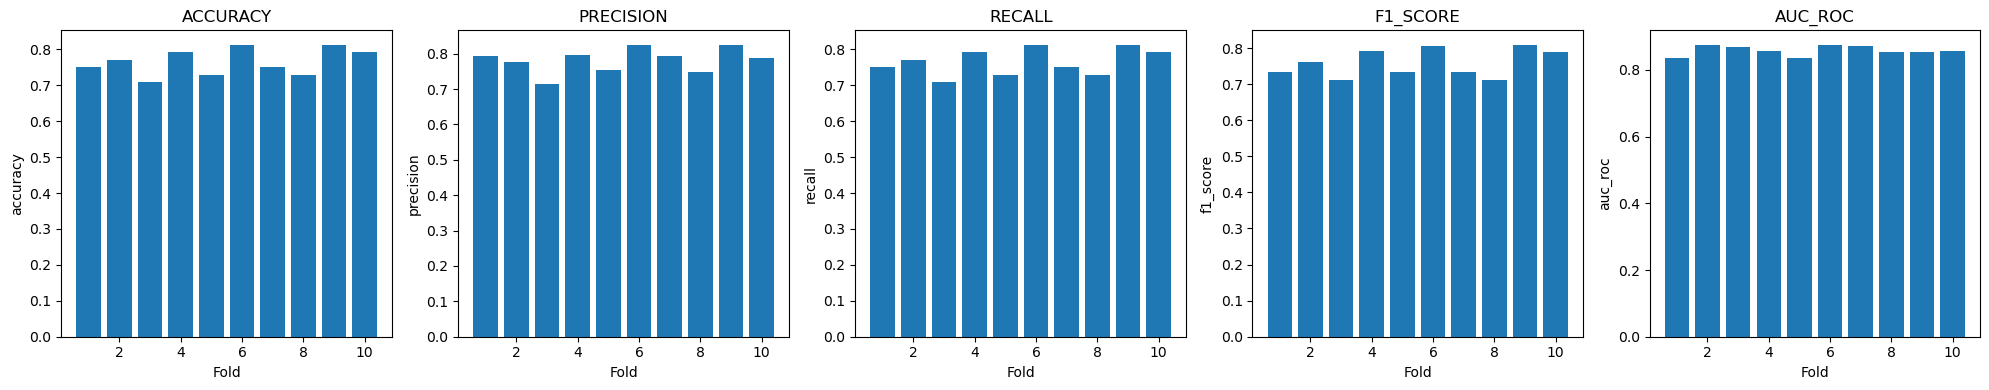

In [33]:

# %%
cv_df = pd.read_csv(os.path.join(results_dir, "crossval_summary.csv"))
metrics = ['accuracy','precision','recall','f1_score','auc_roc']
fig, axs = plt.subplots(1,len(metrics), figsize=(20,4))
for i,m in enumerate(metrics):
    axs[i].bar(cv_df['fold'], cv_df[m]); axs[i].set_title(m.upper()); axs[i].set_xlabel('Fold'); axs[i].set_ylabel(m)
plt.tight_layout(); plt.show()

# ## Step 7: Ensemble Averaging from 10 CV Models


In [34]:

# %%
ess_preds=[]
test_data=torch.load(os.path.join(base_path, f"{task}_test.pt"))
tl=DataLoader(test_data, batch_size=32)
for fold in range(10):
    model = DeepGNNWithEdgeFeatures(test_data[0].x.size(1), test_data[0].edge_attr.size(1), hidden_channels=best_hidden_channels, out_channels=num_classes, dropout=best_dropout).to(device)
    model.load_state_dict(torch.load(os.path.join(results_dir, f"fold{fold+1}_model.pt")))
    model.eval(); outs=[]
    with torch.no_grad():
        for b in tl: outs.append(model(b.to(device)).cpu())
    ess_preds.append(torch.cat(outs,0))
avg=torch.stack(ess_preds).mean(0)
f_pred=avg.argmax(1).numpy(); t_true=torch.cat([d.y for d in test_data]).numpy().astype(int)
pd.DataFrame({'True':t_true,'Pred':f_pred}).to_csv(os.path.join(results_dir,'ensemble_preds.csv'),index=False)
print('✅ Ensemble preds saved')

C:\Users\johng23\AppData\Local\Temp\ipykernel_8584\910334021.py:3: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  test_data=torch.load(os.path.join(base_path, f"{task}_test.p

✅ Ensemble preds saved


# ## Step 7b: Ensemble Model Evaluation – Confusion Matrix & AUC‑ROC


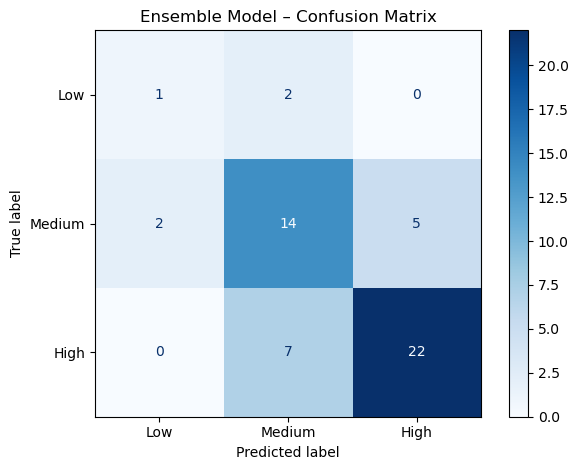

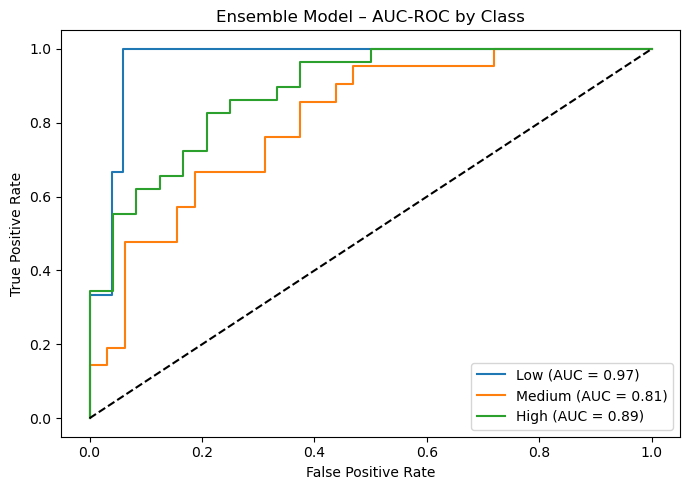

In [44]:

# %%
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, roc_curve, auc
from sklearn.preprocessing import label_binarize
import matplotlib.pyplot as plt

# Load ensemble predictions
ens_df = pd.read_csv(os.path.join(results_dir, 'ensemble_preds.csv'))
y_true_ens = ens_df['True'].values
y_pred_ens = ens_df['Pred'].values

# 1) Confusion matrix
cm = confusion_matrix(y_true_ens, y_pred_ens)
disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                              display_labels=[class_names[i] for i in range(num_classes)])
disp.plot(cmap='Blues')
plt.title("Ensemble Model – Confusion Matrix")
plt.tight_layout()
plt.show()

# 2) AUC‑ROC per class
# Need probability estimates – reload avg_output if available or recompute probabilities
# If you only have hard preds, rerun ensemble loop with model outputs saved as probs:
# avg_probs = torch.stack(ensemble_prob_lists).mean(0).numpy()
avg_output = avg
# For now, assuming you have `avg_probs`:
y_probs = avg_output.softmax(dim=1).numpy()  # or your stored avg_probs
y_true_bin = label_binarize(y_true_ens, classes=np.arange(num_classes))

plt.figure(figsize=(7,5))
for i in range(num_classes):
    fpr, tpr, _ = roc_curve(y_true_bin[:, i], y_probs[:, i])
    plt.plot(fpr, tpr, label=f"{class_names[i]} (AUC = {auc(fpr, tpr):.2f})")
plt.plot([0,1], [0,1], 'k--')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Ensemble Model – AUC‑ROC by Class")
plt.legend()
plt.tight_layout()
plt.show()


# ## Step 8: Final Model Training on Combined Data & Test Evaluation


C:\Users\johng23\AppData\Local\Temp\ipykernel_8584\3026311746.py:10: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  all_data+=torch.load(os.path.join(base_path,f"{task}_train

Epoch 001 | Train Loss: 0.8924 | Val Loss: 0.8788 | Best Val Loss: 0.8788 | Patience: 0
Epoch 002 | Train Loss: 0.7796 | Val Loss: 0.7080 | Best Val Loss: 0.7080 | Patience: 0
Epoch 003 | Train Loss: 0.7024 | Val Loss: 0.6978 | Best Val Loss: 0.6978 | Patience: 0
Epoch 004 | Train Loss: 0.6702 | Val Loss: 0.6310 | Best Val Loss: 0.6310 | Patience: 0
Epoch 005 | Train Loss: 0.6311 | Val Loss: 0.6324 | Best Val Loss: 0.6310 | Patience: 1
Epoch 006 | Train Loss: 0.5927 | Val Loss: 0.5393 | Best Val Loss: 0.5393 | Patience: 0
Epoch 007 | Train Loss: 0.5393 | Val Loss: 0.4709 | Best Val Loss: 0.4709 | Patience: 0
Epoch 008 | Train Loss: 0.5128 | Val Loss: 0.4449 | Best Val Loss: 0.4449 | Patience: 0
Epoch 009 | Train Loss: 0.4519 | Val Loss: 0.4219 | Best Val Loss: 0.4219 | Patience: 0
Epoch 010 | Train Loss: 0.4166 | Val Loss: 0.3433 | Best Val Loss: 0.3433 | Patience: 0
Epoch 011 | Train Loss: 0.3750 | Val Loss: 0.3477 | Best Val Loss: 0.3433 | Patience: 1
Epoch 012 | Train Loss: 0.3312 |

C:\Users\johng23\AppData\Local\Temp\ipykernel_8584\3026311746.py:33: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(os.path.join(results_dir,

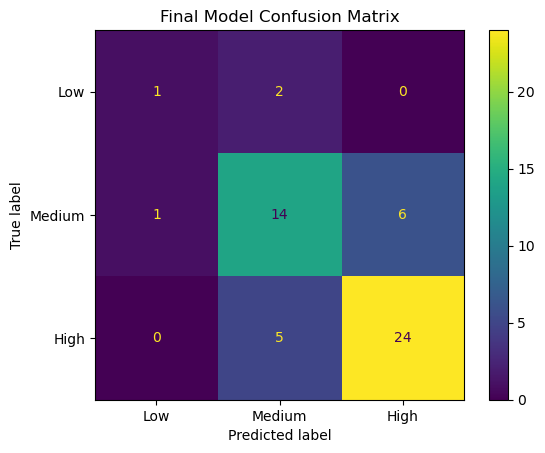

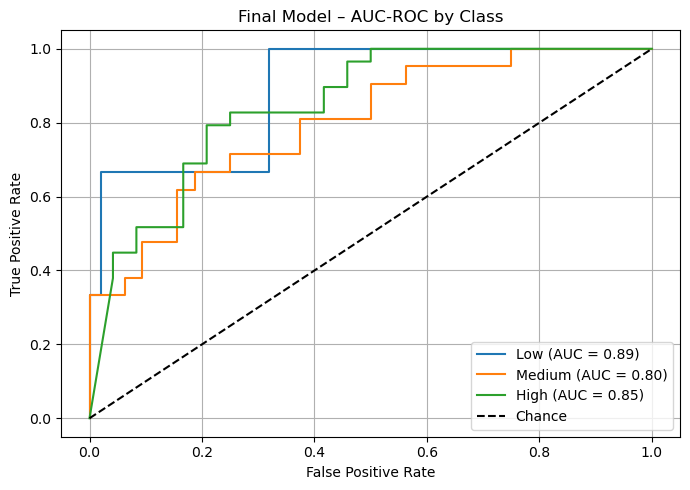

,Accuracy
ensemble,0.698113
final,0.735849


✅ Final metrics saved
✅ Final confusion matrix saved
✅ Final AUC-ROC saved
✅ Final predictions saved


In [40]:

# %%
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize
import matplotlib.pyplot as plt

# Merge train+val
all_data=[]
for fold in range(10):
    all_data+=torch.load(os.path.join(base_path,f"{task}_train_fold{fold}.pt"))
    all_data+=torch.load(os.path.join(base_path,f"{task}_val_fold{fold}.pt"))
# small val
sss=StratifiedShuffleSplit(n_splits=1,test_size=0.1,random_state=seed)
labels=[int(d.y.item()) for d in all_data]
train_idx,val_idx=next(sss.split(all_data,labels))
train_split=[all_data[i] for i in train_idx]; val_split=[all_data[i] for i in val_idx]
tr=DataLoader(train_split,batch_size=32,shuffle=True,worker_init_fn=seed_worker,generator=generator)
vl=DataLoader(val_split,batch_size=32)
model=DeepGNNWithEdgeFeatures(all_data[0].x.size(1),all_data[0].edge_attr.size(1),hidden_channels=best_hidden_channels,out_channels=num_classes,dropout=best_dropout).to(device)
opt=torch.optim.Adam(model.parameters(),lr=best_lr)
sched=torch.optim.lr_scheduler.ReduceLROnPlateau(opt,mode='min',patience=5,factor=0.5,verbose=True)
best_v=1e9;pat=0
for epoch in range(1,301):
    model.train();tot=0
    for b in tr: b=b.to(device);opt.zero_grad();o=model(b);l=F.cross_entropy(o,b.y.long());l.backward();opt.step();tot+=l.item()
    preds,labels=evaluate(model,vl);vloss=F.cross_entropy(preds,labels.long()).item();sched.step(vloss)
    if vloss<best_v:best_v=vloss;pat=0;torch.save(model.state_dict(),os.path.join(results_dir,'final_model.pt'))
    else: pat+=1
    if pat>=10:break
    print(f"Epoch {epoch:03d} | Train Loss: {tot/len(tr):.4f} | Val Loss: {vloss:.4f} | Best Val Loss: {best_v:.4f} | Patience: {pat}")

# test eval
model.load_state_dict(torch.load(os.path.join(results_dir,'final_model.pt')))
td=DataLoader(torch.load(os.path.join(base_path,f"{task}_test.pt")),batch_size=32)
preds,labels=evaluate(model,td);y_pred=preds.argmax(1).numpy();y_true=labels.numpy().astype(int)
# metrics
acc_f=accuracy_score(y_true,y_pred);prec,rec,f1,_=precision_recall_fscore_support(y_true,y_pred,average='weighted')
# confusion
cm=confusion_matrix(y_true,y_pred);disp=ConfusionMatrixDisplay(cm,display_labels=list(class_names.values()));disp.plot()
plt.title('Final Model Confusion Matrix');plt.show()
# final auc
 # Assume y_true is shape (n,) and preds is torch.Tensor of shape (n, num_classes)
probs     = F.softmax(preds, dim=1).cpu().numpy()     # (n, C)
y_true    = labels.numpy().astype(int)                 # (n,)
y_true_bin= label_binarize(y_true, classes=np.arange(num_classes))  # (n, C)

plt.figure(figsize=(7, 5))
for i in range(num_classes):
    fpr, tpr, _ = roc_curve(y_true_bin[:, i], probs[:, i])
    roc_auc     = auc(fpr, tpr)
    plt.plot(fpr, tpr, label=f"{class_names[i]} (AUC = {roc_auc:.2f})")

plt.plot([0, 1], [0, 1], "k--", label="Chance")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Final Model – AUC‑ROC by Class")
plt.legend(loc="lower right")
plt.grid(True)
plt.tight_layout()
plt.show()

# Comparison table
ensemble_df=pd.read_csv(os.path.join(results_dir,'ensemble_preds.csv'))
ensemble_acc=accuracy_score(ensemble_df['True'],ensemble_df['Pred'])
final_metrics = {'ensemble': ensemble_acc, 'final': acc_f}
comp = pd.DataFrame.from_dict(final_metrics, orient='index', columns=['Accuracy'])
display(comp)

# Save final metrics
final_metrics = {
    'accuracy': acc_f,
    'precision': prec,
    'recall': rec,
    'f1_score': f1,
    'auc_roc': roc_auc_score(label_binarize(y_true, classes=np.arange(num_classes)), probs, multi_class='ovr')
}
final_metrics_df = pd.DataFrame(final_metrics, index=[0])
final_metrics_df.to_csv(os.path.join(results_dir, 'final_metrics.csv'), index=False)
print("✅ Final metrics saved")
# Save final confusion matrix
cm_df = pd.DataFrame(cm, index=class_names.values(), columns=class_names.values())
cm_df.to_csv(os.path.join(results_dir, 'final_confusion_matrix.csv'))
print("✅ Final confusion matrix saved")
# Save final AUC-ROC
roc_df = pd.DataFrame({'fpr': fpr, 'tpr': tpr})
roc_auc = auc(fpr, tpr)
roc_df.to_csv(os.path.join(results_dir, 'final_auc_roc.csv'), index=False)
print("✅ Final AUC-ROC saved")
# Save final predictions
preds_df = pd.DataFrame({'True': y_true, 'Pred': y_pred})
preds_df.to_csv(os.path.join(results_dir, 'final_predictions.csv'), index=False)
print("✅ Final predictions saved")


## Step 9: compare ensemble averaging to final model training results

In [41]:
# Comparison table
ensemble_df=pd.read_csv(os.path.join(results_dir,'ensemble_preds.csv'))
ensemble_acc=accuracy_score(ensemble_df['True'],ensemble_df['Pred'])
final_metrics = {'ensemble': ensemble_acc, 'final': acc_f}
comp = pd.DataFrame.from_dict(final_metrics, orient='index', columns=['Accuracy'])
display(comp)

,Accuracy
ensemble,0.698113
final,0.735849
